# Phytoplankton biomass

In [1]:
import xarray as xr
import glob
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import pop_tools
from dask.distributed import LocalCluster

## General setup (see intro notebooks for explanations)

### Connect to cluster

In [2]:
from dask.distributed import LocalCluster
cluster = LocalCluster()
client = cluster.get_client()

/glade/work/eromashkova/miniconda3/envs/ocean-bgc-cookbook-dev/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42153 instead
  warnings.warn(


### Bring in POP grid utilities

In [3]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lons = ds_grid.TLONG
lats = ds_grid.TLAT
depths = ds_grid.z_t * 0.01

In [4]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    # Trick cartopy into doing the right thing:
    # it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    # Periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

### Load the data

In [5]:
case = 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch'
path = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-OMIP2-like-4p2z-run/'+case+'/ocn/proc/tseries/month_1'
coords = {'x':'TLONG','y':'TLAT'}
path

'/glade/campaign/cesm/development/bgcwg/projects/CESM2-OMIP2-like-4p2z-run/g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch/ocn/proc/tseries/month_1'

In [6]:
files = glob.glob(f'{path}/{case}.pop.h.*.195801-202112.nc')
ds=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True,
                       drop_variables=["transport_components", "transport_regions", 'moc_components'], decode_times=True)
ds

<xarray.Dataset>
Dimensions:                           (time: 768, nlat: 384, nlon: 320,
                                       z_t: 60, z_w: 60, lat_aux_grid: 395,
                                       moc_z: 61, d2: 2, z_t_150m: 15,
                                       z_w_bot: 60, z_w_top: 60,
                                       transport_reg: 2, moc_comp: 3,
                                       transport_comp: 5)
Coordinates:
    TLAT                              (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                             (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT                              (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULONG                             (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * lat_aux_grid                      (lat_aux_grid) float32 -79.49 ... 90.0
  * moc_z                             (moc_z) float32 0.0 1e+03 ... 5.5e+05
  * time                              (time) object 1958-02-01 00:00:00 ... 2...
  * z_t                               (z_t) float32 500.0 1.5e+03 ... 5.375e+05
  * z_t_150m                          (z_t_150m) float32 500.0 ... 1.45e+04
  * z_w                               (z_w) float32 0.0 1e+03 ... 5e+05 5.25e+05
  * z_w_bot                           (z_w_bot) float32 1e+03 2e+03 ... 5.5e+05
  * z_w_top                           (z_w_top) float32 0.0 1e+03 ... 5.25e+05
Dimensions without coordinates: nlat, nlon, d2, transport_reg, moc_comp,
                                transport_comp
Data variables: (12/544)
    ADVS                              (time, nlat, nlon) float32 dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
    ANGLE                             (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ANGLET                            (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    DXT                               (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    DXU                               (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    DYT                               (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...                                ...
    x_graze_mesozoo_zint              (time, nlat, nlon) float32 dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
    x_graze_mesozoo_zint_100m         (time, nlat, nlon) float32 dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
    x_graze_microzoo_zint             (time, nlat, nlon) float32 dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
    x_graze_microzoo_zint_100m        (time, nlat, nlon) float32 dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
    zsatarag                          (time, nlat, nlon) float32 dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
    zsatcalc                          (time, nlat, nlon) float32 dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
Attributes:
    title:             g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch
    history:           Wed Jun 21 09:15:38 2023: ncks -O -4 -L 1 /glade/scrat...
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2023-06-13 at 16:35:05.0
    cell_methods:      cell_methods = time: mean ==> the variable values are ...
    NCO:               netCDF Operators version 5.1.4 (Homepage = http://nco....

## Subsetting

In [7]:
variables =['diatC', 'coccoC','spC','diazC',
            'photoC_TOT_zint',
            'photoC_sp_zint','photoC_diat_zint',
            'photoC_diaz_zint','photoC_cocco_zint']
keep_vars=['z_t','z_t_150m','dz','time_bound', 'time', 'TAREA','TLAT','TLONG'] + variables
ds = ds.drop_vars([v for v in ds.variables if v not in keep_vars])

## Taking a quick look

This looks different between winter and summer! (Improve comment)

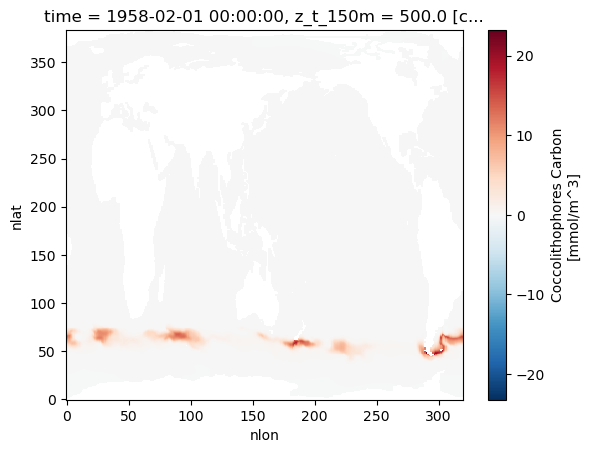

In [8]:
ds.coccoC.isel(time=0,z_t_150m=0).plot()

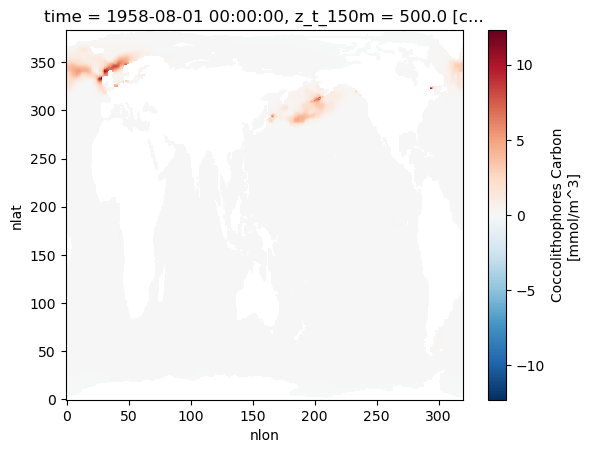

In [9]:
ds.coccoC.isel(time=6,z_t_150m=0).plot()

## Processing - global mean in time

Pull in the functions we defined in the nutrients notebook...

In [10]:
def year_mean(ds):
    """
    Add a docstring
    Source: https://ncar.github.io/esds/posts/2021/yearly-averages-xarray/
    """
    
    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = ds.time.dt.days_in_month

    # Calculate the weights by grouping by 'time.season'
    weights = (
        month_length.groupby("time.year") / month_length.groupby("time.year").sum()
    )

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby("time.year").sum().values, np.ones((len(ds.groupby("time.year")), )))

    # Calculate the weighted average
    return (ds * weights).groupby("time.year").sum(dim="time")

In [11]:
# Take the long-term mean of our data set, processing years and months separately (improve this comment)

ds = year_mean(ds).mean("year")

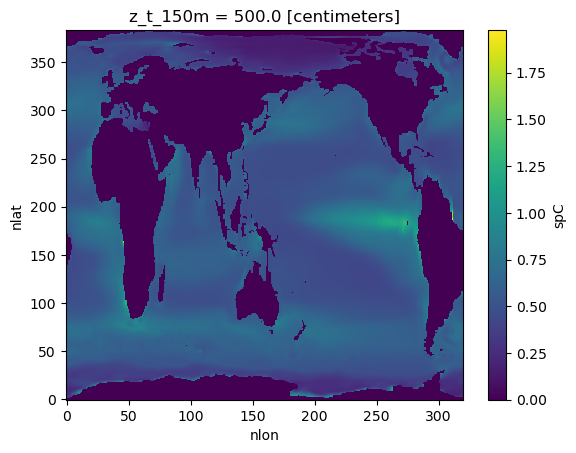

In [12]:
ds['spC'].isel(z_t_150m=0).plot()

## Plotting
### Phytoplankton biomass at the surface

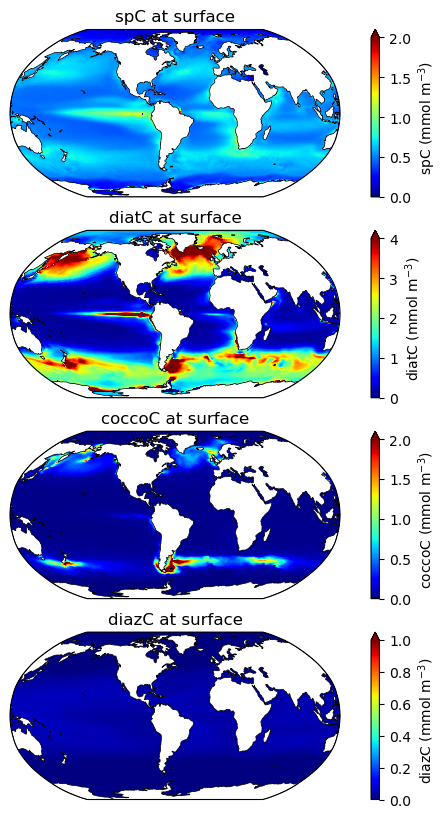

In [16]:
###### 
fig = plt.figure(figsize=(8,10))

ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('spC at surface', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats,  ds.spC.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=2,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='spC (mmol m$^{-3}$)')
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)


ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diatC at surface', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats,  ds.diatC.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=4,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diatC (mmol m$^{-3}$)')
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)


ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('coccoC at surface', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats,  ds.coccoC.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=2,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='coccoC (mmol m$^{-3}$)')
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diazC at surface', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats,  ds.diazC.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=1,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diazC (mmol m$^{-3}$)')
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

### Phytoplankton biomass at 100m

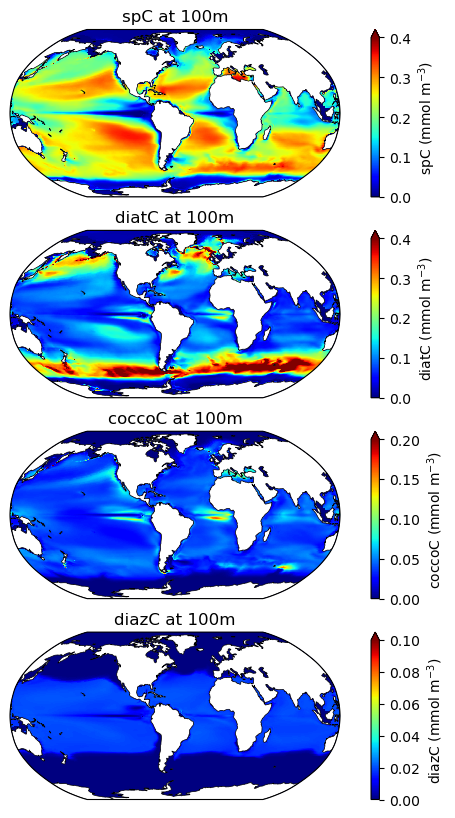

In [17]:
###### 
fig = plt.figure(figsize=(8,10))


ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('spC at 100m', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats,  ds.spC.isel(z_t_150m=9))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=0.4,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='spC (mmol m$^{-3}$)')
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diatC at 100m', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats,  ds.diatC.isel(z_t_150m=9))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=0.4,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diatC (mmol m$^{-3}$)')
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('coccoC at 100m', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats,  ds.coccoC.isel(z_t_150m=9))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=0.2,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='coccoC (mmol m$^{-3}$)')
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diazC at 100m', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats,  ds.diazC.isel(z_t_150m=9))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=0.1,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diazC (mmol m$^{-3}$)')
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

### Productivity

In [ ]:
fig = plt.figure(figsize=(8,10))

ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Small phytoplankton production', fontsize=12)
lon, lat, field = util.adjust_pop_grid(lons, lats, ds.photoC_sp_zint * 864.)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=15,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='sp prod (mmol m$^{-2}$ d$^{-1}$)')

ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diatom production', fontsize=12)
lon, lat, field = util.adjust_pop_grid(lons, lats, ds.photoC_diat_zint * 864.)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=15,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diat prod (mmol m$^{-2}$ d$^{-1}$)')

ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diazotroph production', fontsize=12)
lon, lat, field = util.adjust_pop_grid(lons, lats, ds.photoC_diaz_zint * 864.)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=10,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diaz prod (mmol m$^{-2}$ d$^{-1}$)')

ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Coccolithophore production', fontsize=12)
lon, lat, field = util.adjust_pop_grid(lons, lats, ds.photoC_cocco_zint * 864.)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=10,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='cocco prod (mmol m$^{-2}$ d$^{-1}$)');

In [ ]:
fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Total NPP', fontsize=12)
lon, lat, field = util.adjust_pop_grid(lons, lats,  ds.photoC_TOT_zint*864.)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=60,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='NPP (mmol m$^{-2}$ d$^{-1}$)');

**Add comparison to a satellite NPP dataset, hopefully a cloud available one**

### Globally integrated NPP

In [32]:
ds_glb = util.global_mean(ds, ds_grid, variables,normalize=False).compute()

nmols_to_PgCyr = 1e-9 * 12. * 1e-15 * 365. * 86400.

for v in variables:
    ds_glb[v] = ds_glb[v] * nmols_to_PgCyr        
    ds_glb[v].attrs['units'] = 'Pg C yr$^{-1}$'
    
ds_glb

<xarray.Dataset>
Dimensions:            ()
Data variables:
    photoC_TOT_zint    float64 52.19
    photoC_sp_zint     float64 27.47
    photoC_diat_zint   float64 20.58
    photoC_diaz_zint   float64 1.016
    photoC_cocco_zint  float64 3.111

And close the Dask cluster we spun up at the beginning.

In [18]:
cluster.close()